# Data understanding

In [1]:
#Used for displaying plots below the cell
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [2]:
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)

In [3]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


The dataset seems to contain data about the shopping habits of the customers of a grocery store chain.  
Each row represents an object purchased:  
- BasketID: represents a batch of items bought during the same shopping session  
- BasketDate: date in which the shopping session took place  
- Sale: represents the value of the item, we need to figure out if it refers to a single item or the item*quantity
- CustomerID: identifies a unique customer
- ProdID: identifies a unique product for sale
- ProdDescr: describes the product
- Qta: number of items of the with id ProdID bought

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         471910 non-null  object 
 1   BasketDate       471910 non-null  object 
 2   Sale             471910 non-null  object 
 3   CustomerID       406830 non-null  float64
 4   CustomerCountry  471910 non-null  object 
 5   ProdID           471910 non-null  object 
 6   ProdDescr        471157 non-null  object 
 7   Qta              471910 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.4+ MB


In [5]:
len(df.index)

471910

Only ProdDescr and CustomerID contain null values.

In [6]:
df.describe()

,CustomerID,Qta
count,406830.000000,471910.000000
mean,15287.684160,10.716533
std,1713.603074,231.355136
min,12346.000000,-80995.000000
25%,13953.000000,1.000000
50%,15152.000000,4.000000
75%,16791.000000,12.000000
max,18287.000000,80995.000000


The statistics regarding the CustomerID are meaningless since the assignment of an ID is usually done progressively and without having any additional information on the customer.  
We need to fix the data type situation in order to get a better understanding of the data set.

## Data type conversion  
Let's start by checking out the data type that pandas assigns to the attributes, in order to get an idea of the potential problems.

In [7]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

In [8]:
df = df.convert_dtypes()

In [9]:
df.dtypes

BasketID           string
BasketDate         string
Sale               string
CustomerID          Int64
CustomerCountry    string
ProdID             string
ProdDescr          string
Qta                 Int64
dtype: object

### CustomerID

CustomerID got converted to a reasonable data type while the others became a generic "string".  
We don't however care for CustomerID as a number.

In [10]:
df["CustomerID"] = df["CustomerID"].astype("string")

### BasketDate
Let's convert the BasketDate type from String to datetime, just in case we need to perform some analysis that requires ordinal data.

In [11]:
df.BasketDate = pd.to_datetime(df.BasketDate)

### Sale

The "Sale" attribute is considered a generic object while it should be recognised as a float.  
Let's see why.

In [12]:
df.Sale.map(type)

0         <class 'str'>
1         <class 'str'>
2         <class 'str'>
3         <class 'str'>
4         <class 'str'>
              ...      
541905    <class 'str'>
541906    <class 'str'>
541907    <class 'str'>
541908    <class 'str'>
541909    <class 'str'>
Name: Sale, Length: 471910, dtype: object

In [13]:
df.Sale

0         2,55
1         3,39
2         2,75
3         3,39
4         3,39
          ... 
541905     2,1
541906    4,15
541907    4,15
541908    4,95
541909      18
Name: Sale, Length: 471910, dtype: string

It seems that Sale uses a comma instead of a point to separate the decimal part, so it is considered a "str" instead of a "float64".  
Let's replace the commas in "Sale" with dots in order to have them be recognised as float64 by pandas.

In [14]:
df.Sale = df.Sale.apply(lambda x: x.replace(',','.'))

In [15]:
df.Sale = df.Sale.astype("float64")

Sale is now correctly identified as a float64.

## Data exploration

### Exploration data frame
Used for exploration purposes but not necessarily useful for clustering.  
Initialised with some additional features that could prove useful.

In [16]:
#Auxiliary df to be used throughout the data understanding phase
df_expl = df[["BasketID", "Qta", "Sale"]].copy()

df_expl["QtaPositive"] = 0
df_expl.loc[df_expl["Qta"] > 0, "QtaPositive"] = 1 #Indicates whether the records Qta is positive

df_expl["SalePositive"] = 0
df_expl.loc[df_expl["Sale"] > 0, "SalePositive"] = 1 #Indicates whether the records Sale is positive

df_expl.head()

,BasketID,Qta,Sale,QtaPositive,SalePositive
0,536365,6,2.55,1,1
1,536365,6,3.39,1,1
2,536365,8,2.75,1,1
3,536365,6,3.39,1,1
4,536365,6,3.39,1,1


### BasketID

Let's check why BasketID is not considered an int64 like CustomerID.

In [17]:
nonNumSeries = pd.to_numeric(df.BasketID, errors='coerce').isnull()
# Print the records with BasketIDs containing a non-numeric value
df[nonNumSeries].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


In [18]:
df.loc[nonNumSeries, "BasketID"].str.slice(0,1).unique()

<StringArray>
['C', 'A']
Length: 2, dtype: string

It seems that a good chunk of the BasketID values start with a "C" and some with "A" instead of being just numbers.  

In [19]:
basket_c_df = df.loc[df["BasketID"].str.get(0) == "C"]
len_basket_c = len(basket_c_df)
print(f"Records starting with 'C' (Size: {len_basket_c}):\n")
basket_c_df.head(5)

Records starting with 'C' (Size: 9084):



,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


In [20]:
basket_a_df = df.loc[df["BasketID"].str.get(0) == "A"]
len_basket_a = len(basket_a_df)
print(f"Records starting with 'A' (Size: {len_basket_a}):\n")
basket_a_df.head(10)

Records starting with 'A' (Size: 2):



,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-12-08 14:51:00,-11062.06,<NA>,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-12-08 14:52:00,-11062.06,<NA>,United Kingdom,B,Adjust bad debt,1


There seems to be a strong correlation between the "C" and a negative quantity, this could indicate a customer that asked for a refund.  

There is also some interesting correlation between the "A" start and a ProdDescr containing "Adjust bad debt", maybe the "A" stands for adjust and since the CustomerID in both cases is NaN this could be an operation that concerns only the management of the shop and not something that concerns the customers (which is our primary objective).  
These records, however, are too few to be meaningful, they skew too much the characteristics of the sale data (outliers) and they don't concern the activities of the customers.

Let's try to add a "BasketID type A" and "BasketID type C" binary attribute (0/1) and see if there are correlations.

In [21]:
#Initialise all the cells to 0
df_expl["BasketIDTypeA"] = 0
df_expl["BasketIDTypeC"] = 0

#Set the cells appropriately depending on the BasketID type
df_expl.loc[df["BasketID"].str.get(0) == "A", "BasketIDTypeA"] = 1
df_expl.loc[df["BasketID"].str.get(0) == "C", "BasketIDTypeC"] = 1

#No clue why it doesn't respond with a Warning...
#Remove the initial letter from BasketID where necessary
df_expl.loc[df_expl["BasketID"].str.get(0) == "A", "BasketID"] = df_expl.loc[(df_expl["BasketID"].str.get(0) == "A"), "BasketID"].str.slice(1, -1)
df_expl.loc[df_expl["BasketID"].str.get(0) == "C", "BasketID"] = df_expl.loc[(df_expl["BasketID"].str.get(0) == "C"), "BasketID"].str.slice(1, -1)

df_expl.corr()

,Qta,Sale,QtaPositive,SalePositive,BasketIDTypeA,BasketIDTypeC
Qta,1.000000,-0.001247,0.029379,0.009319,-0.000086,-0.024892
Sale,-0.001247,1.000000,-0.046158,0.013267,-0.271954,0.048286
QtaPositive,0.029379,-0.046158,1.000000,0.183662,0.000299,-0.964446
SalePositive,0.009319,0.013267,0.183662,1.000000,-0.039459,0.007309
BasketIDTypeA,-0.000086,-0.271954,0.000299,-0.039459,1.000000,-0.000288
BasketIDTypeC,-0.024892,0.048286,-0.964446,0.007309,-0.000288,1.000000


The BasketID of type C has a strong negative correlation with the sign of Qta.

In [22]:
df.loc[df["BasketID"].str.get(0) == "C", "ProdDescr"].unique()

<StringArray>
[                           'Discount',     'SET OF 3 COLOURED  FLYING DUCKS',
      'PLASTERS IN TIN CIRCUS PARADE ',    'PACK OF 12 PINK PAISLEY TISSUES ',
    'PACK OF 12 BLUE PAISLEY TISSUES ',   'PACK OF 12 RED RETROSPOT TISSUES ',
         'CHICK GREY HOT WATER BOTTLE',    'PLASTERS IN TIN VINTAGE PAISLEY ',
              'PLASTERS IN TIN SKULLS',            'JAM MAKING SET WITH JARS',
 ...
 'CRYSTAL STUD EARRINGS CLEAR DISPLAY',              'OFFICE MUG WARMER PINK',
   'JUNGLE POPSICLES ICE LOLLY MOULDS',        'SPACEBOY ROCKET LOLLY MAKERS',
             'VINTAGE KID DOLLY CARD ',             'ELEPHANT BIRTHDAY CARD ',
            'AFGHAN SLIPPER SOCK PAIR',  'SMALL SQUARE CUT GLASS CANDLESTICK',
        'HOUSE SHAPE PENCIL SHARPENER',         'PAPER CRAFT , LITTLE BIRDIE']
Length: 1964, dtype: string

What could this mean for the C type? Probably indicates discounts/refunds.

In [23]:
df["BasketID"] = df["BasketID"].astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BasketID       471910 non-null  int64  
 1   Qta            471910 non-null  Int64  
 2   Sale           471910 non-null  float64
 3   QtaPositive    471910 non-null  int64  
 4   SalePositive   471910 non-null  int64  
 5   BasketIDTypeA  471910 non-null  int64  
 6   BasketIDTypeC  471910 non-null  int64  
dtypes: Int64(1), float64(1), int64(5)
memory usage: 29.3 MB


We notice that there are no more anomalies inside BasketID since it can be now converted to int64.

In [110]:
df["BasketID"] = df["BasketID"].astype("string")

Let's try to visualise the situation

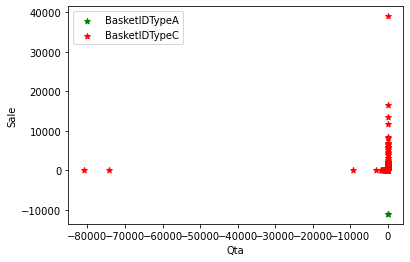

In [25]:
plt.scatter(df_expl.loc[df_expl["BasketIDTypeA"] == 1, 'Qta'], 
            df_expl.loc[df_expl["BasketIDTypeA"] == 1, 'Sale'], color='g', marker='*', label='BasketIDTypeA')
plt.scatter(df_expl.loc[df_expl["BasketIDTypeC"] == 1, 'Qta'], 
            df_expl.loc[df_expl["BasketIDTypeC"] == 1, 'Sale'], color='r', marker='*', label='BasketIDTypeC')
plt.xlabel('Qta')
plt.ylabel('Sale')
plt.legend()
plt.show()

### BasketDate
Let's see how the entries are distributed over time.

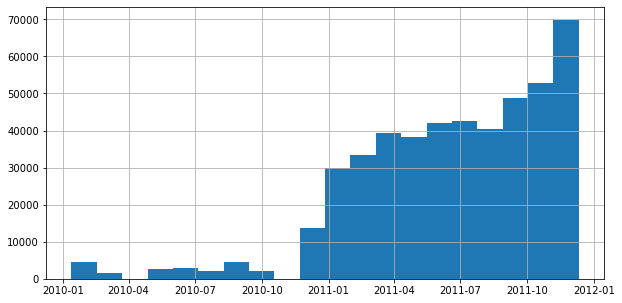

In [26]:
nonNullEntries = df[df["BasketID"].notna()]
k = math.ceil(math.log(len(nonNullEntries), 2) + 1) #Sturge's rule
df["BasketDate"].hist(bins=k, figsize=(10,5))
plt.show()

The number of transactions increases month by month.  
Further analysis taking into account the Qta sold and the Sale value maybe required to get a better picture.

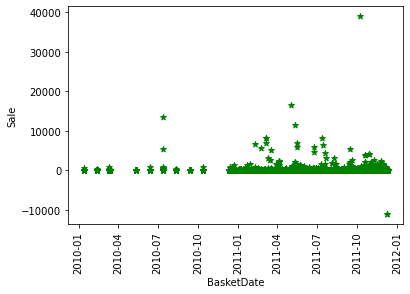

In [28]:
plt.scatter(df['BasketDate'], 
            df['Sale'], color='g', marker='*', label='Data')
plt.xlabel('BasketDate')
plt.xticks(rotation='vertical')
plt.ylabel('Sale')
plt.show()

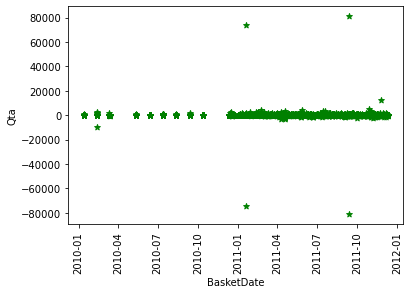

In [29]:
plt.scatter(df['BasketDate'], 
            df['Qta'], color='g', marker='*', label='Data')
plt.xlabel('BasketDate')
plt.xticks(rotation='vertical')
plt.ylabel('Qta')
plt.show()

Plenty of potential outliers.

### Sale
We need to figure out if the Sale value refers to the cost of a single item or cost of item * Qta

In [79]:
df.sort_values(by="ProdID").head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
109443,545637,2011-04-03 12:16:00,0.85,15514,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,2
121872,546790,2011-03-17 10:26:00,0.85,14713,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,6
171573,551429,2011-04-28 15:05:00,0.00,<NA>,United Kingdom,10002,<NA>,-3
22380,538167,2010-09-12 18:58:00,0.85,14713,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,12
93152,544278,2011-02-17 12:01:00,0.85,15382,United Kingdom,10002,INFLATABLE POLITICAL GLOBE,12


It seems that Sale doesn't change if the Qta is changed... let's verify it further.

In [105]:
df.corr()

,Sale,Qta
Sale,1.000000,-0.001247
Qta,-0.001247,1.000000


There doesn't seem to be a correlation in general between Sale and Qta, so they are indipendent variables and therefore Sale is the cost of the signle item.

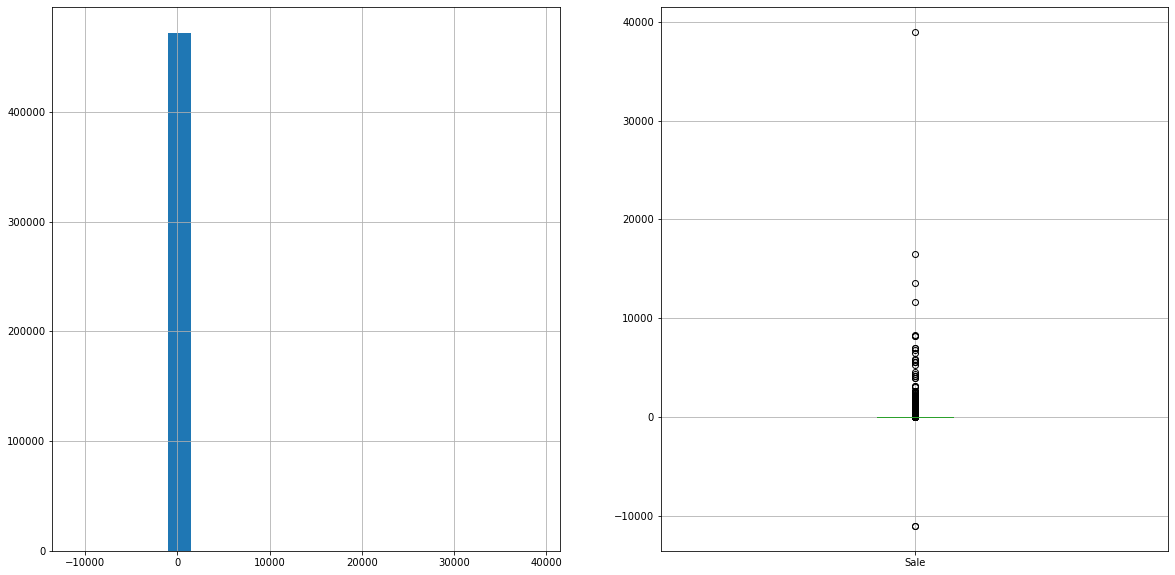

In [30]:
#Visualize the Sale distribution
fig = plt.figure(figsize=(20, 10)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
nonNullEntries = df[df["Sale"].notna()]
k = math.ceil(math.log(len(nonNullEntries), 2) + 1) #Sturge's rule
df["Sale"].hist(bins=k)

plt.subplot2grid(fig_dims, (0, 1))
df.boxplot(column=["Sale"])
plt.show()

Visualisation in this case don't seem to be all that useful.  
Note that the median is near the 0.

In [31]:
df["Sale"].describe()

count    471910.000000
mean          4.030945
std          83.769380
min      -11062.060000
25%           1.250000
50%           2.080000
75%           3.750000
max       38970.000000
Name: Sale, dtype: float64

Judging by the quartiles and max/min values there seem to be some values that skew the results.

### CustomerID

Let's see why the number of non-null CustomerID entries is so low and if there are any interesting properties to be found.

In [32]:
df_expl["CustomerID"] = df["CustomerID"]

df_expl["CustomerIDNull"] = 0
df_expl.loc[df_expl["CustomerID"].isna(), "CustomerIDNull"] = 1

df_expl.corr()["CustomerIDNull"]

Qta              -0.014533
Sale              0.017026
QtaPositive       0.021508
SalePositive     -0.125717
BasketIDTypeA     0.005147
BasketIDTypeC    -0.048027
CustomerIDNull    1.000000
Name: CustomerIDNull, dtype: float64

No interesting correlation.

In [ ]:
#for v in null_customer.BasketID.unique():
#    test = df.loc[df["BasketID"] == v].loc[lambda i: i["CustomerID"].notna()]
#    if(not test.empty):
#        print(test)
#This provided no output so we can assume that there are no entries containing a 
#non-NaN with same BasketID as the ones that have CustomerID NaN

The mystery will stay unsolved for now

### Customer country

<AxesSubplot:>

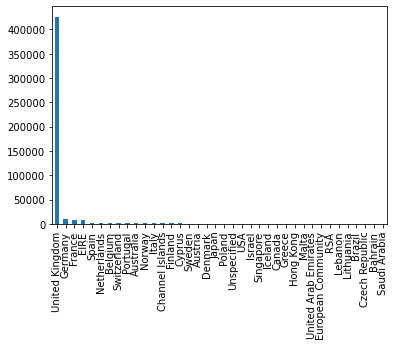

In [33]:
df["CustomerCountry"].value_counts().plot(kind='bar')

The majority of the operations take place in the United Kingdom.  
It could be interesting to however take into account the revenue by country and see which is more profitable relative to the number of orders.

In [109]:
countryList = df["CustomerCountry"].sort_values().unique()
country_df = pd.DataFrame(data=countryList, columns=["Country"])

df["ProductSaleQta"] = df["Sale"]*df["Qta"]

#PROBLEM: didn't take into account that Sale refers to a single item
for country in countryList:
    country_df.loc[country_df["Country"] == country, "TotalSale"] = df.loc[df["CustomerCountry"] == country, "ProductSaleQta"].sum()

df.drop(columns=["ProductSaleQta"])
country_df.sort_values(by="TotalSale", ascending=False)

,Country,TotalSale
36,United Kingdom,7432121.524
24,Netherlands,284661.540
10,EIRE,256516.290
14,Germany,221698.210
13,France,197014.930
0,Australia,137077.270
33,Switzerland,56030.030
31,Spain,54774.580
3,Belgium,40910.960
32,Sweden,36595.910


### ProdID
Let's find out why this wasn't converted to a number.

In [39]:
df.loc[df["ProdID"].str.isnumeric(), ("ProdID", "ProdDescr")].value_counts() #Records with ProdIDs containing only numbers

ProdID  ProdDescr                        
22423   REGENCY CAKESTAND 3 TIER             2042
47566   PARTY BUNTING                        1569
20725   LUNCH BAG RED RETROSPOT              1491
84879   ASSORTED COLOUR BIRD ORNAMENT        1470
22720   SET OF 3 CAKE TINS PANTRY DESIGN     1332
                                             ... 
84620   BLUE GINGHAM ROSE CUSHION COVER         1
22181   check                                   1
23427   damaged                                 1
23035   check                                   1
20867   ?                                       1
Length: 3279, dtype: int64

In [35]:
nonNumBoolSeries = pd.to_numeric(df["ProdID"], errors="coerce").isnull()
nonNum = df.loc[nonNumBoolSeries] #Records with ProdIDs containing only letters
nonNum.loc[nonNum["ProdID"].str.isalpha(), ("ProdID", "ProdDescr")].value_counts()

ProdID     ProdDescr                 
POST       POSTAGE                       1221
M          Manual                         506
DOT        DOTCOM POSTAGE                 338
D          Discount                        77
S          SAMPLES                         26
AMAZONFEE  AMAZON FEE                      17
CRUK       CRUK Commission                 16
DCGSSBOY   BOYS PARTY BAG                   6
PADS       PADS TO MATCH ALL CUSHIONS       4
DCGSSGIRL  GIRLS PARTY BAG                  4
B          Adjust bad debt                  2
m          Manual                           1
dtype: int64

# Data preparation

## Additional features

Let's add some new features into the data frame

In [111]:
unq_cust_id = df["CustomerID"].sort_values().unique()[0:-1] #Remove NaN value, last value
cust_df = pd.DataFrame(data=unq_cust_id, columns=["CustomerID"]) #Dataframe containing customer features

#Total number of items bought by customer
IFeature = df.groupby(["CustomerID"]).Qta.sum()
cust_df = cust_df.merge(IFeature, on="CustomerID").rename(columns={"Qta":"I"})

#Total number of unique items bought by customer
IuFeature = df.groupby(["CustomerID"]).ProdID.nunique()
cust_df = cust_df.join(IuFeature, on="CustomerID").rename(columns={"ProdID":"Iu"})

#Max number of item bought by customer across all shopping sessions
BasketIDQtaSum= df.groupby(["CustomerID", "BasketID"]).Qta.sum()
ImaxFeature = BasketIDQtaSum.groupby(["CustomerID"]).max()
cust_df = cust_df.join(ImaxFeature, on="CustomerID").rename(columns={"Qta":"Imax"})

#The Shannon entropy on the purchasing behaviour of the customer (sum -p_items * log2(p_items))
#Potential problem: p could be a negative value!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cust_prod_tot = df.groupby(["CustomerID", "ProdID"]).Qta.sum()
probSeries = (cust_prod_tot/IFeature).rename({"Qta":"P_prod_customer"})
logSeries = np.log2(probSeries)
entropy = -1*probSeries*logSeries
EFeature = entropy.groupby(["CustomerID"]).sum()
cust_df = cust_df.join(EFeature, on="CustomerID").rename(columns={"Qta":"E"})

cust_df.head()

/usr/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CustomerID,I,Iu,Imax,E
0,12346,0,1,74215,0.000000
1,12347,2458,103,676,6.015601
2,12348,2341,22,1254,4.233442
3,12349,631,73,631,5.802215
4,12350,197,17,197,3.977269


In [42]:
cust_df.corr()

,I,Iu,Imax,E
I,1.000000,0.440926,0.287746,0.200461
Iu,0.440926,1.000000,0.108965,0.667396
Imax,0.287746,0.108965,1.000000,0.033832
E,0.200461,0.667396,0.033832,1.000000


Interesting correlation between E and Iu

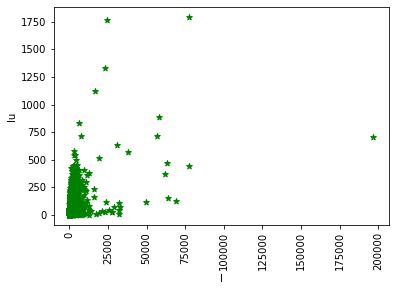

In [43]:
plt.scatter(cust_df['I'], 
            cust_df['Iu'], color='g', marker='*', label='Data')
plt.xlabel('I')
plt.xticks(rotation='vertical')
plt.ylabel('Iu')
plt.show()